<h1 align="center">Tutorial: Simulación de modelos de distribución de riqueza en Julia + CUDA.jl</h1>

<p align="center"><strong>Workshop de Julia</strong></p>

<p align="center"><em>FAMAF, 29 de Julio de 2024</em></p>

<p align="center"><em>Nicolás Vazquez</em></p>

---

Este tutorial pretende ser una introducción a la programación en Julia y a la programación en GPU con CUDA.jl. Para ello, vamos a simular un modelo de distribución de riqueza en una población de agentes.

Este desarrollo es reciente y se encuentra en constante evolución. Por lo tanto, es posible que algunas cosas cambien en el futuro. Si encuentran algún error o tienen alguna sugerencia, por favor, no duden en contactarme.

## Objetivos

- Introducir algunos elementos básicos de la biblioteca `CUDA.jl`.
- Implementar los elementos básicos que requiere una simulación numérica en una GPU (kernels, programación en arrays/matrices).
- Implementar un modelo de distribución de riqueza en una población de agentes.
- Realizar una primer implementación de simulaciones que corran en paralelo en una misma tarjeta gráfica.

## Qué modelo vamos a simular?

El modelo que vamos a simular es el modelo de distribución de riqueza de Bruce Boghosian y colaboradores, conocido como _'Modelo Yard-Sale extendido'_. En su versión más básica, el modelo consiste en una población de $N$ agentes, cada uno con una cantidad de riqueza $w_i$. La riqueza total del sistema es $W = \sum_{i=1}^N w_i$, que es una cantidad conservada en el tiempo. No obstante, la riqueza de un agente $i$ en general es una función del tiempo $w_i = w_i(t)$, lo cual se asume implícitamente durante el resto de este texto.

Brevemente, el modelo Yard-Sale extendido es una generalización del modelo Yard-Sale, propuesto por Chakraborti en 2002 [2,3], que es un modelo de intercambio de riqueza entre agentes. En el modelo Yard-Sale, la riqueza de un agente $i$ en el tiempo $t$ es $w_i(t)$. En cada paso de tiempo, dos agentes $i$ y $j$ son seleccionados al azar. Se sortea al azar una variable aleatoria $\eta\in [-1,1]$. Si $\eta=1(-1)$, entonces el agente $i(j)$ le transfiere riqueza al agente $j(i)$. La cantidad de riqueza que se transfiere es proporcional al mínimo de de las riquezas de los dos agentes. 

$$
\begin{equation}
\Delta w_{ij} = \sqrt{\gamma \Delta t} \eta_{ij} \min(w_i, w_j) 
\end{equation}
\tag{1}
$$

La variable estocástica $\eta$ de acuerdo a esta definición, verifica que $<\eta> = 0$ y $<\eta^2> = 1$.

La cantidad $f = \sqrt{\gamma \Delta t}$ es la tasa de intercambio de riqueza, que puede interpretarse como la fracción de riqueza que está en juego en una transacción. 

En la versión extendida del modelo Yard-Sale, se introducen dos parámetros nuevos:

- A cada paso de tiempo, se le cobra a cada agente $i$ un impuesto $\chi\Delta t w_i$, por lo que en total se recauda un impuesto total $\chi\Delta t W$. Esta riqueza recaudada se distribuye de manera uniforme entre todos los agentes. Es decir, cada agente reciba una cantidad $\chi\Delta t W/N$. De manera efectiva, esto significa una redistribución de riqueza neta sobre cada agente igual a $\chi\Delta t(W/N - w_i)$.

- La variable estocástica $\eta$ incorpora un sesgo que es proporcional a la diferencia de riqueza entre los agentes $i$ y $j$ que participan en la transacción. 

$$
\begin{equation}
<\eta_{ij}> = \zeta \sqrt{\frac{\Delta t}{\gamma}} \frac{w_i-w_j}{W/N}
\end{equation}
\tag{2}
$$

El parámetro $\zeta$ es la constante de proporcionalidad que calibra el sesgo, y que Boghosian define como "Wealth Attained Advantage" (WAA). 

Recapitulando, el modelo Yard-Sale extendido se define por las siguientes reglas:

$$
\begin{align}
\Delta w_{ij} &= \sqrt{\gamma \Delta t} \eta_{ij} \min(w_i, w_j)  + \chi\Delta t\Big(\frac{W}{N} - w_i\Big) \tag{3}\\
<\eta_{ij}> &= \zeta \sqrt{\frac{\Delta t}{\gamma}} \frac{(w_i-w_j)}{W/N} \tag{4}\\
<\eta^2> &= 1 \tag{5}
\end{align}
$$

Este modelo es interesante porque presenta una transición de fase de segundo orden, entre un estado de riqueza distribuida y un estado condensado, en el que un único agente del sistema concentra una fracción significativa o macroscópica de la riqueza total.

Tomando como parámetro de orden la fracción de riquezas $\phi$ acumulada por el agente más rico del sistema en el estado estacionario, se puede demostrar que 

$$
\begin{equation}
\phi(\chi/\zeta) = \begin{cases}
1 - \frac{\chi}{\zeta} & \text{si } \frac{\chi}{\zeta} < 1 \\
\frac{1}{N} & \text{si } \frac{\chi}{\zeta} > 1
\end{cases}
\end{equation}
\tag{6}
$$

## La implementación de la simulación numérica

La idea de este tutorial es implementar este modelo en una GPU. Una forma de hacerlo sería intentar paralelizar las transacciones en la tarjeta, de manera que cada agente sea un thread en la GPU. Sin embargo, esta solución trae problemas de sincronización y de acceso a memoria compartida, que no son triviales de resolver, si bien hay formas de hacerlo usando mutex lock y tecnologías de ese estilo [2].

Una manera posible de resolver este problema es pensar en la simulación como un problema de matrices. 

$$
\begin{equation}
\vec{w}(t+1) = \vec{w}(t) + \sqrt{\gamma \Delta t} \sum_{j} \mathbf{\eta}_{ij} \circ \mathbf{M}_{ij} + \chi\Delta t\Big(\frac{W}{N} - \vec{w}\Big)
\end{equation}
\tag{6}
$$

Donde $\vec{w}$ es un vector de riquezas de tamaño $N$, $\mathbf{\eta}$ es una matriz antisimétrica de tamaño $N\times N$ cuyos elementos son las variables aleatorias $\eta_{ij}$, y $\circ$ es el producto elemento a elemento. La matriz $\mathbf{M}$ es una matriz simétrica de tamaño $N\times N$ cuyos elementos son el mínimo de las riquezas de los agentes $i$ y $j$.

Haciendo abuso de notación, podríamos escribir 
$$
\begin{equation}
\mathbf{M} := \min(\vec{w}, \vec{w}^T)
\end{equation}
\tag{7}
$$

o bien, siendo más precisos,

$$
\begin{equation}
\mathbf{M}_{ij} = \min(w_i, w_j)
\end{equation}
\tag{8}
$$
Esta implementación calcula todas las transacciones posibles en el sistema y las ejecuta en paralelo, por lo que se evitan los problemas de sincronización.

Vamos a usar el hecho de que tanto la matriz de riquezas y de variables aleatorias son matrices simétricas y antisimétricas, para reducir la cantidad de operaciones que necesitamos hacer.

Básicamente, el problema queda resuelto si podemos calcular la matriz $\mathbf{M}$ y la matriz $\mathbf{\eta}$ en paralelo. Para ello vamos a escribir un kernel que calcule estas matrices en paralelo.

### Qué es un kernel?

Un kernel es una función que se ejecuta en la GPU. En CUDA, un kernel es una función que se ejecuta en un thread de la GPU. La función se ejecuta en paralelo en todos los threads de la GPU, y cada thread tiene un identificador único que se puede usar para identificarlo.

Esta es la ventaja más grande de la programación en GPU: podemos ejecutar una misma función en paralelo en muchos threads, lo que nos permite hacer una gran cantidad de cálculos en paralelo.

En cierto sentido, escribir un código que se ejecute en la GPU se puede reducir a pensar cómo podemos paralelizar las operaciones que necesitamos hacer implementando los kernels adecuados.

### Cómo se ejecuta un kernel?

Para ejecutar un kernel en CUDA.jl, primero debemos definir la función que queremos ejecutar en la GPU. Luego, debemos definir el tamaño de los bloques y de los threads que vamos a usar. Finalmente, debemos llamar a la función `CUDA.@cuda` con la función que queremos ejecutar, el tamaño de los bloques y de los threads, y los argumentos de la función.

### Cómo se definen los bloques y los threads?

En CUDA, los threads se organizan en bloques. Cada bloque tiene un tamaño fijo, y cada bloque tiene un identificador único. Los bloques se organizan en una grilla, y cada bloque tiene un identificador único en la grilla. Los threads dentro de un bloque también tienen un identificador único, que se puede usar para identificarlos.

### Cómo se calcula el identificador de un thread?

En CUDA, el identificador de un thread se calcula de la siguiente manera:

- `threadIdx.x`: El identificador del thread en la dimensión x.
- `blockIdx.x`: El identificador del bloque en la dimensión x.
- `blockDim.x`: El tamaño del bloque en la dimensión x.
- `gridDim.x`: El tamaño de la grilla en la dimensión x.

El identificador de un thread se calcula como `threadIdx.x + (blockIdx.x - 1) * blockDim.x`.
Si trabajamos en problemas de más de una dimensión, podemos usar `threadIdx.y`, `blockIdx.y`, `blockDim.y`, `gridDim.y`, etc.

### Cómo se calcula el tamaño de los bloques y de los threads?

A priori, esto es un hiperparámetro que debemos definir. En general, el tamaño de los bloques y de los threads depende de la cantidad de threads que podemos ejecutar en la GPU que estemos utilizando.

En ciertos problemas, se puede hallar un tamaño óptimo de bloques y de threads que maximice la eficiencia de la GPU. En general, esto se hace mediante un proceso de prueba y error. Dentro de la librería `CUDA.jl`, hay funciones que nos permiten estimar el tamaño óptimo de los bloques y de los threads, como la Occupancy API [3]. 

Para escribir el código vamos a proceder de la siguiente manera:
 1. Implementaremos un kernel que calcule la matriz $\mathbf{M}$.
 2. Implementaremos generadores números aleatorios para la matriz $\mathbf{\eta}$.
 3. Implementaremos un kernel que calcule los intercambios de riqueza.
 4. Implementaremos un kernel que actualice las riquezas de los agentes.

Empecemos!

## Primer código: Una única simulación paralela en GPU

In [1]:
# 1. Importamos las librerías necesarias
## Si no está instalado CUDA, se instala con el siguiente comando
# using Pkg
# Pkg.add("CUDA")
using CUDA
using Plots # Para graficar

In [2]:
# Chequeemos que la GPU está disponible
if CUDA.functional()
    device = CUDA.device()
    println("GPU is available:")
    println("Name: ", CUDA.name(device))
    println("Capability: ", CUDA.capability(device))
    println("Total memory: ", CUDA.total_memory() / 1024^3, " GB")
else
    println("GPU is not available.")
end

GPU is available:
Name: NVIDIA GeForce GTX 1660 SUPER
Capability: 7.5.0
Total memory: 5.99957275390625 GB


In [3]:
# 2. Definición de parámetros generales del modelo

N = 128 # Número de agentes
WN = 1.0f0 # Riqueza promedio 
W = WN*N # Riqueza total

f = 0.005 # Fracción de riqueza intercambiada en cada transacción

# Temperatura
chi = 0.1f0
zeta = 1.0f0
# El modelo predice que el agente rico va a acumular 1-chi/zeta = 90% de la riqueza total

# Constantes útiles
chif_N = chi*f/N
zeta_W = zeta/W

## Salvamos constantes en la GPU para reducir comunicación CPU-GPU	
N_GPU = CUDA.fill(N,1) 
WN_GPU = CUDA.fill(WN,1)
W_GPU = CUDA.fill(W,1)
f_GPU = CUDA.fill(f,1)
chif_N_GPU = CUDA.fill(chif_N,1)
zeta_W_GPU = CUDA.fill(zeta_W,1)

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.0078125

La matriz de interacciones es antisimétrica (ver ecuación 6), por lo tanto podemos reducir la cantidad de cálculos que necesitamos hacer a la mitad. Es decir, si en una red totalmente conectada de $N$ agentes, sólo necesitamos calcular $N(N-1)/2$ transacciones. Vamos a aprovechar este hecho para resolver el problema en un arreglo unidimensional, en vez de calcular todos los términos de las matrices. 

Las interacciones del sistema se pueden representar en un array de tamaño $N(N-1)/2 \times 2$. Cada fila del array es un par de agentes $(i,j)$ que interactúan, donde $i < j$ para aprovechar la simetría.

In [4]:
# Matriz de índices para seleccionar agentes
idx_matrix = [ [i,j] for i in 1:N for j in i+1:N] 
idx_matrix = transpose(hcat(idx_matrix...)) # Transponemos para que cada fila sea un par de índices

# Almacenamos la matriz de índices en la GPU
idx_matrix_GPU = CuArray(idx_matrix) # Convertimos a CuArray para almacenar en la GPU
idx_matrix_GPU[1:10,:] # Mostramos los primeros 10 pares de índices

10×2 CuArray{Int64, 2, CUDA.Mem.DeviceBuffer}:
 1   2
 1   3
 1   4
 1   5
 1   6
 1   7
 1   8
 1   9
 1  10
 1  11

In [5]:
# Cantidad de interacciones = N*(N-1)/2
m = size(idx_matrix,1) # Cantidad de interacciones (enlaces)
m_GPU = CUDA.fill(m,1) # Salvamos en la GPU
m == N*(N-1) ÷ 2 || error("Error en la cantidad de interacciones")

true

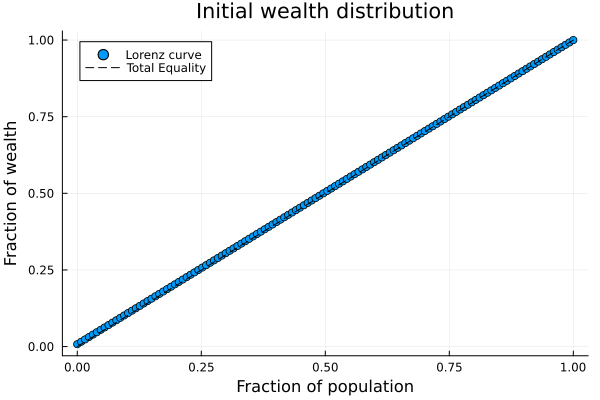

In [6]:
# Inicializamos la riqueza de cada agente
initial_conditions = "uniform" # Elegir "uniform" o "random"

if initial_conditions == "uniform"
    w_GPU = CUDA.fill(WN,N) # Todos los agentes comienzan con riqueza WN
elseif initial_conditions == "random"
    w_GPU = CUDA.rand(N)
    w_GPU *= W/sum(w_GPU) # Normalizamos para que la riqueza total sea W
else
    error("Initial conditions not recognized")
end

# Copiar el vector de riqueza a la CPU para graficar
w = Array(w_GPU);

# Graficamos la distribución inicial de riqueza
scatter(
    range(0,1,N),
    cumsum(sort(w))/W,
    ylabel="Fraction of wealth",xlabel="Fraction of population",label="Lorenz curve",
    title="Initial wealth distribution"
)
plot!([0,1],[0,1],label="Total Equality",linestyle=:dash,color=:black)

In [7]:
# 3. Primer kernel: Mínimo de riqueza entre dos agentes
function min_kernel!(w_GPU,Min_gpu,idx_matrix_GPU,m_GPU)
    # idx del thread
    i = threadIdx().x + blockDim().x * (blockIdx().x - 1)
    if i <= m_GPU[]
        # Obtenemos los índices de los agentes
        agent_i, agent_j = idx_matrix_GPU[i,1], idx_matrix_GPU[i,2]
        # Calculamos el mínimo de riqueza entre los dos agentes y lo guardamos en M_gpu
        Min_gpu[i] = min(w_GPU[agent_i],w_GPU[agent_j])
    end
    return
end

min_kernel! (generic function with 1 method)

In [8]:
# TEST: Ejecución del kernel

# Definimos la cantidad de threads por bloque
threads_per_block = 1024 # Elección común para sistemas 1D
# Definimos la cantidad de bloques
blocks = Int(ceil(m/threads_per_block))

# Creamos un vector para almacenar el mínimo de riqueza entre cada par de agentes
Min_GPU = CUDA.zeros(m)

# Llamamos al kernel
@cuda blocks=blocks threads=threads_per_block min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU)

CUDA.HostKernel for min_kernel!(CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceMatrix{Int64, 1}, CuDeviceVector{Int64, 1})

In [9]:
# Ejemplo de uso de Occupancy API

# Definimos el kernel que vamos a lanzar
kernel = @cuda launch=false min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU)
# Inspeccionemos el kernel
max_threads = CUDA.maxthreads(kernel) # Máximo de threads por bloque

1024

In [10]:
# Este comando nos muestra la cantidad óptima de recursos a utilizar para el kernel
config = CUDA.launch_configuration(kernel.fun)
@info "Optimal configuration" config

┌ Info: Optimal configuration
└   config = (blocks = 22, threads = 1024)


***Nota***: el número óptimo para esta GPU es 22, sin embargo para este tamaño de sistema necesitamos más bloques, puesto que 22*1024 = 22528 < 130816. Esto no es un problema, pero debemos tener en cuenta que utilizar más bloques podría afectar al rendimiento. Para solucionar esto, sería necesario una grilla stride en el kernel (cosa que yo no sé hacer).

Ya tenemos escrito un kernel que nos calcula el valor mínimo de riqueza entre agentes para todas las transacciones. Lo siguiente sería construir un kernel que nos calcule los sesgos que deben tener las variables aleatorias $\eta_{ij}$.

Con una elección de $\Delta t$ adecuada, se puede mostrar que nuestro problema se reduce a calcular el sesgo $b$ introducido por la ecuación 4. Es decir, queremos sortear números en $[1,-1]$ tal que salga elegido $1$ con probabilidad (1+b)/2. El sesgo $b$ se puede escribir como

$$
\begin{equation}
b = \zeta \frac{w_i-w_j}{W}
\end{equation}
\tag{9}
$$

In [11]:
# 4. Números aleatorios sesgados
function probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU)
    # idx del thread
    i = threadIdx().x + blockDim().x * (blockIdx().x - 1)
    if i <= m_GPU[]
        # Obtenemos los índices de los agentes
        agent_i, agent_j = idx_matrix_GPU[i,1], idx_matrix_GPU[i,2]
        # Calculamos el número aleatorio sesgado y lo guardamos en bias_GPU
        probs_GPU[i] = 0.5f0 *(1.0f0 + zeta_W_GPU[]*(w_GPU[agent_i] - w_GPU[agent_j]))
    end
    return
end

probs_kernel! (generic function with 1 method)

In [12]:
# Llamamos al kernel
threads = config.threads
blocks = cld(m,threads) # Entero mayor o igual al cociente m/threads

# Creamos un vector para almacenar los números aleatorios sesgados
probs_GPU = CUDA.zeros(m)

# Llamamos al kernel
@cuda blocks=blocks threads=threads probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU)

CUDA.HostKernel for probs_kernel!(CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceMatrix{Int64, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Int64, 1})

In [13]:
# Calculamos eta aleatorios a partir de números aleatorios y las probabilidades sesgadas
r_GPU = CUDA.rand(m) # Números aleatorios
eta_GPU = 2.0f0 * (r_GPU .< probs_GPU) .- 1.0f0 # eta_GPU vale 1.0 si r < prob, -1.0 si r >= prob

8128-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -1.0
  1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮
 -1.0
 -1.0
  1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0

In [14]:
# 5. Actualizamos la riqueza de los agentes
function make_exchanges_kernel!(w_GPU,dw_GPU,Min_GPU,eta_GPU,idx_matrix_GPU,m_GPU,f_GPU,chif_N_GPU,WN_GPU)
    i = threadIdx().x + blockDim().x * (blockIdx().x - 1)
    if i <= m_GPU[]
        agent_i, agent_j = idx_matrix_GPU[i,1], idx_matrix_GPU[i,2]
        # Actualizamos la riqueza de los agentes
        # Δw_ij, avoid negative wealth
        wi,wj = w_GPU[agent_i],w_GPU[agent_j]
        dw_GPU[agent_i,agent_j] = f_GPU[] * eta_GPU[i] * Min_GPU[i] + chif_N_GPU[] * (WN_GPU[] - wi)
        # Δw_ji = -Δw_ij
        dw_GPU[agent_j,agent_i] = - f_GPU[] * eta_GPU[i] * Min_GPU[i] + chif_N_GPU[] * (WN_GPU[] - wj)
    end
    return
end

# Creamos una matriz para almacenar los cambios de riqueza
dw_GPU = CUDA.zeros(N,N)

# Llamamos al kernel
@cuda blocks=blocks threads=threads make_exchanges_kernel!(w_GPU,dw_GPU,Min_GPU,eta_GPU,idx_matrix_GPU,m_GPU,f_GPU,chif_N_GPU,WN_GPU)

CUDA.HostKernel for make_exchanges_kernel!(CuDeviceVector{Float32, 1}, CuDeviceMatrix{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceMatrix{Int64, 1}, CuDeviceVector{Int64, 1}, CuDeviceVector{Float64, 1}, CuDeviceVector{Float64, 1}, CuDeviceVector{Float32, 1})

Hemos podido dividir el problema en partes más pequeñas, segmentando todos los cálculos necesarios en los diferentes kernels. Ahora, vamos a juntar todos estos pasos en una sóla función que simule el modelo de distribución de riqueza.

In [15]:
function run_EYSM_gpu(N,WN,f,chi,zeta,steps,initial_conditions)
    # Guardamos las constantes en la GPU
    N_GPU = CUDA.fill(N,1)
    WN_GPU = CUDA.fill(WN,1)
    W_GPU = CUDA.fill(WN*N,1)
    f_GPU = CUDA.fill(f,1)
    chif_N_GPU = CUDA.fill(chi*f/N,1)
    zeta_W_GPU = CUDA.fill(zeta/W_GPU[],1)

    # Condiciones iniciales
    if initial_conditions == "uniform"
        w_GPU = CUDA.fill(WN,N) # Todos los agentes comienzan con riqueza WN
    elseif initial_conditions == "random"
        w_GPU = CUDA.rand(N)
        w_GPU *= W_GPU[]/sum(w_GPU) # Normalizamos para que la riqueza total sea W
    else
        error("Initial conditions not recognized")
    end
    # Array para almacenar la evolución temporal del sistema (esto es para test, no es necesario y es muy costoso)
    w_t = zeros(Float32,steps+1,N)
    w_t[1,:] = Array(w_GPU) # Guardamos la condición inicial
    # Matriz de índices para seleccionar agentes
    idx_matrix = [ [i,j] for i in 1:N for j in i+1:N]
    idx_matrix = transpose(hcat(idx_matrix...))
    idx_matrix_GPU = CuArray(idx_matrix)

    # Cantidad de interacciones = N*(N-1)/2
    m = size(idx_matrix,1)
    m_GPU = CUDA.fill(m,1)

    # Definimos la cantidad de threads por bloque
    threads_per_block = 1024
    # Definimos la cantidad de bloques
    blocks = cld(m,threads_per_block)

    # Arrays para ir almacenando los mínimos, números aleatorios, etc.
    Min_GPU = CUDA.zeros(m)
    probs_GPU = CUDA.zeros(m)
    dw_GPU = CUDA.zeros(N,N)
    # Loop temporal
    for t in 1:steps
        # Llamamos al kernel para calcular los mínimos
        @cuda blocks=blocks threads=threads_per_block min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU)
        # Llamamos al kernel para calcular los números aleatorios sesgados
        @cuda blocks=blocks threads=threads_per_block probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU)
        # Calculamos eta aleatorios a partir de números aleatorios y las probabilidades sesgadas
        r_GPU = CUDA.rand(m_GPU[]) # Números aleatorios
        eta_GPU = 2.0f0 * (r_GPU .< probs_GPU) .- 1.0f0 # eta_GPU vale 1.0 si r < prob, -1.0 si r >= prob
        # Llamamos al kernel para hacer las transacciones
        @cuda blocks=blocks threads=threads_per_block make_exchanges_kernel!(w_GPU,dw_GPU,Min_GPU,eta_GPU,idx_matrix_GPU,m_GPU,f_GPU,chif_N_GPU,WN_GPU)
        # Actualizamos la riqueza de los agentes
        w_GPU .+= sum(dw_GPU,dims=2)
        # Corregimos la deriva en la riqueza total
        w_GPU *= W_GPU[]/sum(w_GPU)
        # Guardamos la riqueza en el array de evolución
        w_t[t+1,:] = Array(w_GPU) # Guardamos la condición inicial (CPU)
    end
    return w_t
end

run_EYSM_gpu (generic function with 1 method)

In [16]:
N = 128
WN = 1.0f0
f = 0.01f0
chi = 0.1f0
zeta = 1.0f0
steps = 1000
initial_conditions = "uniform"
w_t = run_EYSM_gpu(N,WN,f,chi,zeta,steps,initial_conditions) # Corremos el modelo (GPU). Esta celda puede tardar unos segundos.

┌ Warning: Performing scalar indexing on task Task (runnable) @0x0000022c4be25180.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\Nico\.julia\packages\GPUArraysCore\GMsgk\src\GPUArraysCore.jl:149


1001×128 Matrix{Float32}:
 1.0       1.0        1.0        …  1.0        1.0        1.0
 0.93      0.91       1.13          1.03       0.91       1.17
 0.978569  0.852989   1.05237       1.13907    0.981189   1.20093
 1.05318   0.61015    0.917656      0.942178   0.950958   1.29471
 1.16154   0.653048   0.858658      0.768724   0.960839   1.28368
 1.31729   0.645914   0.829761   …  0.697291   1.02301    1.38042
 1.49101   0.59845    0.858576      0.688062   0.955063   1.44986
 1.54408   0.614617   0.878646      0.646993   1.07409    1.41534
 1.62325   0.574106   0.794401      0.637693   1.02722    1.4046
 1.61744   0.603643   0.813474      0.678044   1.15921    1.66075
 1.6081    0.681549   0.984788   …  0.706527   1.07273    1.66361
 1.63609   0.630341   1.09872       0.832694   1.09884    1.85741
 1.55844   0.634096   1.40828       0.661538   1.17969    1.90726
 ⋮                               ⋱  ⋮                     
 0.147947  0.0839012  0.0699067     0.0428675  0.0756649  0.08217

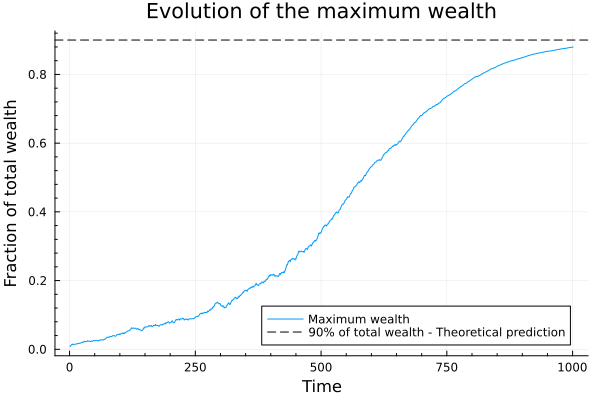

In [17]:
plot(maximum(w_t,dims=2)/N,minorticks=true,label="Maximum wealth",ylabel="Fraction of total wealth",xlabel="Time",title="Evolution of the maximum wealth")
hline!([0.9],label="90% of total wealth - Theoretical prediction",color=:black,linestyle=:dash)

## Segundo código: paralelización masiva de simulaciones en GPU

El código anterior nos permite correr simulaciones del modelo en GPU. Sin embargo, nada nos impide pensar en que podríamos aprovechar toda la capacidad de cómputo de nuestra tarjeta e intentar implementar varias simulaciones a la vez. En nuestro formato matricial de encarar el problema, esto sería simplemente extender una dimensión más todos los arrays con los que hemos trabajado. De este modo, si por ejemplo queremos correr $s$ simulaciones en paralelo, el arreglo de riquezas ahora debe ser una matriz de dimensión $s\times N$, el array de las interacciones debe ser una matriz de dimensión $s\times N(N-1)/2 \times 2$, y así sucesivamente.

Además, nada nos permite pensar que nuestro arreglo de interacciones podría representar una red compleja arbitraria, y no únicamente una red totalmente conectada. De este modo, podríamos pensar en implementar un modelo de distribución de riqueza en una red compleja, en la que los agentes interactúan con sus vecinos más cercanos. 

Es decir, lo que vamos a hacer ahora es una corrida paralela de simulaciones en la GPU del modelo sobre una topología compleja.

In [18]:
using Graphs 

### Kernels paralelos

In [19]:
# Kernel para calcular el mínimo de riqueza entre dos agentes
function min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU,n_sims_GPU)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    if i <= n_sims_GPU[] && j <= m_GPU[]
        idx_i, idx_j = idx_matrix_GPU[j,1], idx_matrix_GPU[j,2] # Get the indices of the agents
        Min_GPU[i,j] = min(w_GPU[i,idx_i],w_GPU[i,idx_j]) # Compute the minimum wealth between the two agents
    end
    return
end
# Kernel para calcular los números aleatorios sesgados
function probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU,n_sims_GPU)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    if i <= n_sims_GPU[] && j <= m_GPU[]
        idx_i, idx_j = idx_matrix_GPU[j,1], idx_matrix_GPU[j,2] # Get the indices of the agents
        probs_GPU[i,j] = 0.5f0 *(1.0f0 + zeta_W_GPU[]*(w_GPU[i,idx_i] - w_GPU[i,idx_j])) # Compute the biased random number
    end
    return
end
# Kernel para hacer las transacciones
function make_exchanges_kernel!(w_GPU,dw_GPU,eta_GPU,Min_GPU,idx_matrix_GPU,f_GPU,chif_N_GPU,WN_GPU,m_GPU,n_sims_GPU)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    if i <= n_sims_GPU[] && j <= m_GPU[]
        idx_i, idx_j = idx_matrix_GPU[j,1], idx_matrix_GPU[j,2] # Get the indices of the agents
        # Compute the wealth exchange
        dw_GPU[i,idx_i,idx_j] = f_GPU[] * eta_GPU[i,j] * Min_GPU[i,j] + chif_N_GPU[] * (WN_GPU[] - w_GPU[i,idx_i])
        dw_GPU[i,idx_j,idx_i] = - f_GPU[] * eta_GPU[i,j] * Min_GPU[i,j] + chif_N_GPU[] * (WN_GPU[] - w_GPU[i,idx_j])
    end
    return
end

make_exchanges_kernel! (generic function with 2 methods)

Podemos organizar los threads de la GPU en arreglos bidimensionales. Qué beneficios trae esto? Por ejemplo, los hilos dentro de un mismo bloque pueden comunicarse a través de memoria compartida, lo que reduce la cantidad de accesos a memoria global. Además (en principio), podríamos aprovechar la estructura de la red para reducir la cantidad de cálculos que necesitamos hacer.

In [21]:
## PARA TEST Y DEBUGGING 

# Definimos la red que vamos a simular
N = 128
n_sims = 32 # Cantidad de simulaciones paralelas
g = CompleteGraph(N) # Red completa

# Definimos los parámetros del modelo
WN = 1.0f0
f = 0.05f0
chi = 0.1f0
zeta = 1.0f0
steps = 2500
initial_conditions = "uniform"
## TEST DE KERNELS

# Definición de parámetros
# Carga de constantes en la GPU

N_GPU = CUDA.fill(N,1)
n_sims_GPU = CUDA.fill(n_sims,1)
WN_GPU = CUDA.fill(WN,1)
W_GPU = CUDA.fill(WN*N,1)
f_GPU = CUDA.fill(f,1)
chif_N_GPU = CUDA.fill(chi*f/N,1)
zeta_W_GPU = CUDA.fill(zeta/W_GPU[],1)
# --- #
initial_conditions = "random"
# Condiciones iniciales
if n_sims == 1
    if initial_conditions == "uniform"
        w_GPU = CUDA.fill(WN,N) # Todos los agentes comienzan con riqueza WN
    elseif initial_conditions == "random"
        w_GPU = CUDA.rand(n_sims,N)
        w_GPU .*= W_GPU[] / sum(w_GPU) # Normalizamos para que la riqueza total sea WN
    else
        error("Initial conditions not recognized")
    end
elseif n_sims > 1
    if initial_conditions == "uniform"
        w_GPU = CUDA.fill(WN,n_sims,N) # Todos los agentes comienzan con riqueza WN
    elseif initial_conditions == "random"
        w_GPU = CUDA.rand(n_sims,N)
        w_GPU .*= W_GPU[] ./ sum(w_GPU,dims=2) # Normalizamos para que la riqueza total sea WN
    else
        error("Initial conditions not recognized")
    end
else
    error("n_sims must be greater than 0")
end;

# Matriz de índices para seleccionar agentes
idx_matrix = [ [e.src,e.dst] for e in edges(g)]
idx_matrix = transpose(hcat(idx_matrix...))
m = size(idx_matrix,1)
idx_matrix_GPU = CuArray(idx_matrix)
m_GPU = CUDA.fill(m,1)

1-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 8128

In [22]:
# Kernel para calcular el mínimo de riqueza entre dos agentes
Min_GPU = CUDA.zeros(n_sims,m)

# Definiendo la cantidad de threads por bloque
threads_per_block = (32,32)
# Definiendo la cantidad de bloques
blocks = (cld(n_sims,threads_per_block[1]),cld(m,threads_per_block[2]))

@cuda blocks=blocks threads=threads_per_block min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU,n_sims_GPU)

Min_GPU # Mostramos los primeros 10 mínimos de riqueza

32×8128 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.432255   1.6875      1.70987    …  0.977119   0.696144   0.696144
 0.521692   0.578621    1.24624       0.0987366  0.538076   0.0987366
 1.53935    0.565729    0.133062      0.485404   0.4241     0.4241
 0.0227872  0.0227872   0.0227872     0.0734206  0.0734206  0.255831
 1.42123    1.4815      1.4815        0.224837   1.10423    0.224837
 1.27835    0.609157    0.551649   …  0.98593    0.903527   0.903527
 0.0566587  0.0566587   0.0566587     1.02818    1.15491    1.02818
 1.88629    1.16853     0.866971      1.1565     1.1565     1.48308
 0.916642   0.916642    0.761822      0.474037   0.474037   0.724033
 0.165104   0.827788    0.827788      0.350544   0.878537   0.350544
 0.519329   0.964473    0.266905   …  1.40218    1.10699    1.10699
 0.498147   0.00226535  0.116218      0.960832   0.175629   0.175629
 1.0178     0.587128    1.0178        0.412336   0.368038   0.368038
 ⋮                                 ⋱  ⋮                

In [23]:
# Kernel para calcular los números aleatorios sesgados

probs_GPU = CUDA.zeros(n_sims,m)

# Definiendo la cantidad de threads por bloque
threads_per_block = (32,32)
# Definiendo la cantidad de bloques
blocks = (cld(n_sims,threads_per_block[1]),cld(m,threads_per_block[2]))

@cuda blocks=blocks threads=threads_per_block probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU,n_sims_GPU)

probs_GPU # Mostramos los primeros 10 números aleatorios sesgados

32×8128 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.505327  0.500424  0.500337  0.500797  …  0.501978  0.503075  0.501098
 0.50283   0.502608  0.499841  0.501863     0.505277  0.503561  0.498284
 0.500326  0.504129  0.505819  0.501972     0.49794   0.500239  0.5023
 0.49795   0.494322  0.498563  0.499257     0.494263  0.499287  0.505025
 0.500235  0.498591  0.499181  0.50119      0.506415  0.50298   0.496565
 0.498149  0.502614  0.502839  0.498811  …  0.501519  0.501841  0.500322
 0.492863  0.498023  0.495793  0.492803     0.500495  0.49768   0.497185
 0.500377  0.503181  0.504359  0.507117     0.498696  0.498724  0.500028
 0.496905  0.497561  0.500605  0.502215     0.498833  0.499023  0.50019
 0.502589  0.496875  0.497364  0.501569     0.504252  0.502189  0.497938
 0.501739  0.499641  0.502725  0.49809   …  0.501056  0.502209  0.501153
 0.502835  0.504772  0.504327  0.503418     0.497856  0.503067  0.505211
 0.498151  0.501682  0.497588  0.499379     0.494765  0.500173  0.505408
 ⋮

In [24]:
# η aleatorios
r_GPU = CUDA.rand(n_sims,m)

eta_GPU = 2.0f0 * (r_GPU .< probs_GPU) .- 1.0f0

eta_GPU[1:end,1:10] # Mostramos los primeros 10 η aleatorios

32×10 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 -1.0  -1.0   1.0  -1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0
 -1.0   1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0  -1.0   1.0
  1.0  -1.0   1.0   1.0   1.0  -1.0   1.0  -1.0   1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0   1.0  -1.0  -1.0   1.0   1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0   1.0  -1.0
 -1.0   1.0   1.0  -1.0   1.0   1.0  -1.0  -1.0   1.0  -1.0
 -1.0   1.0   1.0  -1.0   1.0  -1.0   1.0  -1.0  -1.0   1.0
  1.0   1.0   1.0   1.0  -1.0  -1.0   1.0   1.0   1.0   1.0
 -1.0  -1.0  -1.0   1.0   1.0   1.0   1.0   1.0  -1.0  -1.0
  1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0  -1.0   1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0  -1.0   1.0  -1.0   1.0  -1.0
  1.0   1.0   1.0   1.0   1.0  -1.0   1.0   1.0  -1.0  -1.0
  1.0   1.0  -1.0   1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0
  ⋮                             ⋮                      
  1.0   1.0   1.0  -1.0  -1.0  -1.0   1.0   1.0  -1.0   1.0
 -1.0   1.0  -1.0   1.0   1.0   1.0  -1.0  -1.0   1.0 

In [25]:
# Kernel para hacer las transacciones

dw_GPU = CUDA.zeros(n_sims,N,N)

# Definiendo la cantidad de threads por bloque
threads_per_block = (16,32) # La configuración (32,32) excede la cantidad de registros disponibles en mi tarjeta.
# Definiendo la cantidad de bloques
blocks = (cld(n_sims,threads_per_block[1]),cld(m,threads_per_block[2]))

@cuda blocks=blocks threads=threads_per_block make_exchanges_kernel!(w_GPU,dw_GPU,eta_GPU,Min_GPU,idx_matrix_GPU,f_GPU,chif_N_GPU,WN_GPU,m_GPU,n_sims_GPU)

dw_GPU[11,1:10,1:10] # Mostramos los primeros 10 cambios de riqueza

10×10 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  0.0         -0.025965    -0.0482222   …  -0.0198962    0.00633534
  0.0259852    0.0         -0.0259477      -0.0198788    0.00635273
  0.0482214    0.0259642    0.0            -0.0198998   -0.00633616
 -0.0133166   -0.0133166   -0.0133166      -0.0133166    0.00636259
  0.0482059   -0.0259841   -0.0528373       0.0198799   -0.00635167
  0.0257035   -0.0256655    0.0257035   …   0.0199166    0.00635295
  0.0481986   -0.0259915    0.0527945       0.0198725    0.0063089
 -0.0482237    0.0259664   -0.0500997       0.0198975   -0.00633403
  0.0199211    0.0199211    0.0199211       0.0          0.00635747
 -0.00629984  -0.00629984   0.00636807     -0.00629984   0.0

In [26]:
function EYSM_parallel_gpu(n_sims::Int,g::Graph{Int64},WN::Float32,f::Float32,chi::Float32,zeta::Float32,initial_conditions::String,steps::Int64,seed::Int)
    # Set the seed
    CUDA.Random.seed!(seed)

    # Get the number of agents
    N = nv(g)
    # Total wealth
    W = WN*N

    # We need the edgelist to compute the interactions
    edgelist = edges(g)
    idx_matrix = [ [e.src,e.dst] for e in edgelist ]
    idx_matrix = transpose(hcat(idx_matrix...))
    m = size(idx_matrix,1) # Number of interactions
    # Store the edgelist in the GPU
    idx_matrix_GPU = CuArray(idx_matrix)

    # Store constants in the GPU
    N_GPU = CUDA.fill(N,1)
    WN_GPU = CUDA.fill(WN,1)
    W_GPU = CUDA.fill(W,1)
    f_GPU = CUDA.fill(f,1)
    chif_N_GPU = CUDA.fill(chi*f/N,1)
    zeta_W_GPU = CUDA.fill(zeta/W,1)
    m_GPU = CUDA.fill(m,1)
    n_sims_GPU = CUDA.fill(n_sims,1)

    # We need to store the wealth of each agent
    # Also, we make the distinction between one run and multiple runs
    # If n_sims is not valid, it throws an error.
    if n_sims > 1 # If we have multiple runs
        if initial_conditions == "uniform"
            w_GPU = CUDA.fill(WN,n_sims,N) # All agents start with WN
        elseif initial_conditions == "random"
            w_GPU = CUDA.rand(n_sims,N)
            # Normalize the wealth in each run to W
            w_GPU .*= W_GPU[] ./ sum(w_GPU,dims=2)
        else
            error("Initial conditions not recognized")
        end
    elseif n_sims == 1 # If we have only one run
        if initial_conditions == "uniform" 
            w_GPU = CUDA.fill(WN,N) # All agents start with WN
        elseif initial_conditions == "random"
            w_GPU = CUDA.rand(N)
            # Normalize the wealth to W
            w_GPU .*= W_GPU[] / sum(w_GPU)
        else
            error("Initial conditions not recognized")
        end
    else # Otherwise, the number of runs is not valid
        error("Number of simulations must be an integer greater than 0")
    end

    # Arrays to store the minimum wealth, biased random numbers, and wealth exchanges
    if n_sims > 1
        Min_GPU = CUDA.zeros(n_sims,m)
        probs_GPU = CUDA.zeros(n_sims,m)
        eta_GPU = CUDA.zeros(n_sims,m)
        dw_GPU = CUDA.zeros(n_sims,N,N)
    else
        Min_GPU = CUDA.zeros(m)
        probs_GPU = CUDA.zeros(m)
        eta_GPU = CUDA.zeros(m)
        dw_GPU = CUDA.zeros(N,N)
    end
    # Define threads and blocks for the kernels
    if n_sims == 1
        threads = 1024
        blocks = cld(m,threads)
    else
        threads_1 = (32,32) # For the min_kernel and probs_kernel
        threads_2 = (16,32) # For the make_exchanges_kernel -> (32,32) exceeds the number of registers in my GPU
        blocks_1 = cld(n_sims,threads_1[1]), cld(m,threads_1[2])
        blocks_2 = cld(n_sims,threads_2[1]), cld(m,threads_2[2])
    end
    # Loop over time
    if n_sims == 1
        for t in 1:steps
            # Compute the minimum wealth between each pair of agents
            @cuda blocks=blocks threads=threads min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU)
            # Compute the biased random numbers
            @cuda blocks=blocks threads=threads probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU)
            # Compute the eta values
            r_GPU = CUDA.rand(m)
            eta_GPU = 2.0f0 * (r_GPU .< probs_GPU) .- 1.0f0
            # Compute the wealth exchanges
            @cuda blocks=blocks threads=threads make_exchanges_kernel!(w_GPU,dw_GPU,eta_GPU,Min_GPU,idx_matrix_GPU,f_GPU,chif_N_GPU,WN_GPU,m_GPU)
            # Update the wealth of the agents
            w_GPU .+= sum(dw_GPU,dims=2)
            # If there are negative values, set them to zero
            w_GPU = max.(w_GPU,0.0f0)
            # Correct the drift in the total wealth
            w_GPU .*= W_GPU[] / sum(w_GPU)
        end
    else 
        for t in 1:steps
            # Compute the minimum wealth between each pair of agents
            @cuda blocks=blocks_1 threads=threads_1 min_kernel!(w_GPU,Min_GPU,idx_matrix_GPU,m_GPU,n_sims_GPU)
            # Compute the biased random numbers
            @cuda blocks=blocks_1 threads=threads_1 probs_kernel!(w_GPU,probs_GPU,idx_matrix_GPU,zeta_W_GPU,m_GPU,n_sims_GPU)
            # Compute the eta values
            r_GPU = CUDA.rand(n_sims,m)
            eta_GPU = 2.0f0 * (r_GPU .< probs_GPU) .- 1.0f0
            # Compute the wealth exchanges
            @cuda blocks=blocks_2 threads=threads_2 make_exchanges_kernel!(w_GPU,dw_GPU,eta_GPU,Min_GPU,idx_matrix_GPU,f_GPU,chif_N_GPU,WN_GPU,m_GPU,n_sims_GPU)
            # Update the wealth of the agents
            w_GPU .+= sum(dw_GPU,dims=3)
            # If there are negative values, set them to zero
            w_GPU = max.(w_GPU,0.0f0)
            # Correct the drift in the total wealth
            w_GPU .*= W_GPU[] ./ sum(w_GPU,dims=2)
        end
    end
    return Array(w_GPU)
end

EYSM_parallel_gpu (generic function with 1 method)

In [28]:
# Definimos la red que vamos a simular
N = 128
n_sims = 32 # Cantidad de simulaciones paralelas
g = barabasi_albert(N,2,seed=42) # Red de Barabási-Albert

# Definimos los parámetros del modelo
WN = 1.0f0
f = 0.05f0
chi = 0.05f0
zeta = 1.0f0
steps = 5000
initial_conditions = "uniform"

"uniform"

In [29]:
# Corremos el modelo
w = EYSM_parallel_gpu(n_sims,g,WN,f,chi,zeta,initial_conditions,steps,42)

32×128 Matrix{Float32}:
 0.0162637   0.0069454   0.0298366   …  2.01214     0.0126553   2.18303
 0.114878    0.0176993   0.00552232     0.018683    0.00477688  0.0175735
 0.039712    8.82529     0.0166214      2.48008     2.20814     0.00603855
 0.00792701  5.88514     0.0204286      0.68752     2.02462     0.00410368
 0.0428539   0.0180152   0.0334301      0.0124308   2.38044     0.00579944
 0.0231706   8.53421     0.0314366   …  0.0105607   0.0112751   0.00715877
 0.00629451  0.00529675  0.0119214      0.00502588  2.25885     0.00830276
 0.178911    0.00830062  6.7038         2.81342     0.0154375   0.011424
 0.119179    5.7556      0.00355672     0.00924623  2.85511     0.00813294
 7.53938     0.199498    0.0129671      0.0140281   0.0218159   1.96381
 6.98297     0.0690398   0.214232    …  0.025355    0.0297394   2.07129
 0.00228515  6.48116     0.0212746      0.0115694   0.0154902   0.0162109
 0.0144473   6.98672     0.00986854     0.340336    1.06059     0.00909627
 ⋮            

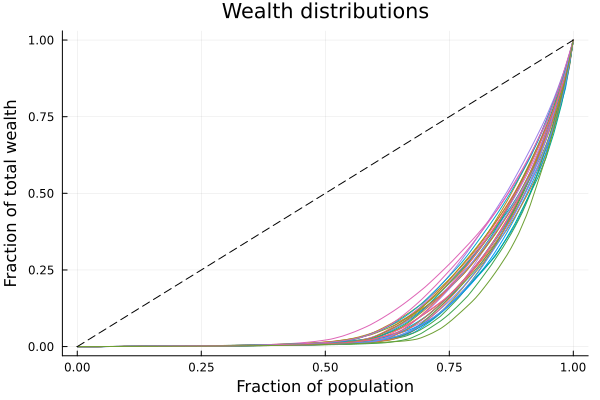

In [34]:
# Podemos ver todas las distribuciones de riqueza al final de la simulación
p = plot(title="Wealth distributions",xlabel="Fraction of population",ylabel="Fraction of total wealth")
for ww in eachrow(w)
    p = plot!(
        range(0,1,N),
        cumsum(sort(ww))/sum(ww),
        label="",
        )
end

p = plot!([0, 1], [0, 1], color="black", linestyle=:dash, label="")

display(p)

## Referencias

1. Boghosian, B. M., Devitt-Lee, A., Johnson, M., Li, J., Marcq, J. A., & Wang, H. (2017). Oligarchy as a phase transition: The effect of wealth-attained advantage in a Fokker–Planck description of asset exchange. Physica A: Statistical Mechanics and Its Applications, 476, 15–37. https://doi.org/10.1016/j.physa.2017.01.071
2. Cuevas, S. (2022). cuTradeNet (0.1.0). Zenodo. https://doi.org/10.5281/zenodo.7381215
3. GPU Programming in Julia | Workshop | JuliaCon 2021 (n.d.). Retrieved July 29, 2024, from [https://www.youtube.com/watch?v=J3QX5vJ3Z8A ](https://www.youtube.com/watch?v=Hz9IMJuW5hU)
4. Besard, T., Foket, C., & De Sutter, B. (2017). Effective Extensible Programming: Unleashing Julia on GPUs. https://doi.org/10.1109/TPDS.2018.2872064